In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [3]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'


In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)

In [5]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,isotope_intensities_l from features where batch==\'1to1\' and number_of_runs_extracted==10', db_conn)
db_conn.close()

In [6]:
# group them into sequence and charge
sequence_charge_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge']):
    sequence_charge_l.append((group_name[0], group_name[1]))
sequence_charge_df = pd.DataFrame(sequence_charge_l, columns=['sequence','charge'])

# take a subsample of sequences that have appeared in all the runs
sequences_for_analysis_df = pd.merge(sequence_charge_df.sample(n=1), sequences_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

# expand the raw points for the monoisotope
# index 4 of isotope_intensities_l is the raw points for each isotope
sequences_for_analysis_df['isotope_raw_points'] = sequences_for_analysis_df.apply(lambda row: [pd.DataFrame(d[4], columns=['mz','scan','frame_id','retention_time_secs','intensity']).to_dict('records') for d in json.loads(row.isotope_intensities_l)], axis=1)


In [7]:
sequences_for_analysis_df

,sequence,charge,file_idx,isotope_intensities_l,isotope_raw_points
0,GASWIDTADGSANHR,2,8,"[[2731.0, false, 2731.0, false, [[779.35219300...","[[{'mz': 779.3521930039146, 'scan': 480.0, 'fr..."
1,GASWIDTADGSANHR,2,15,"[[2817.0, false, 2817.0, false, [[779.35218009...","[[{'mz': 779.3521800940096, 'scan': 495.0, 'fr..."
2,GASWIDTADGSANHR,2,6,"[[2890.0, false, 2890.0, false, [[779.35214866...","[[{'mz': 779.3521486698943, 'scan': 490.0, 'fr..."
3,GASWIDTADGSANHR,2,19,"[[2213.0, false, 2213.0, false, [[779.35216799...","[[{'mz': 779.3521679929985, 'scan': 492.0, 'fr..."
4,GASWIDTADGSANHR,2,1,"[[2360.0, false, 2360.0, false, [[779.35219605...","[[{'mz': 779.3521960596511, 'scan': 489.0, 'fr..."
5,GASWIDTADGSANHR,2,2,"[[2086.0, false, 2086.0, false, [[779.35214120...","[[{'mz': 779.3521412069634, 'scan': 495.0, 'fr..."
6,GASWIDTADGSANHR,2,10,"[[2729.0, false, 2729.0, false, [[779.35217737...","[[{'mz': 779.3521773734359, 'scan': 476.0, 'fr..."
7,GASWIDTADGSANHR,2,18,"[[2800.0, false, 2800.0, false, [[779.35218350...","[[{'mz': 779.3521835049767, 'scan': 478.0, 'fr..."
8,GASWIDTADGSANHR,2,11,"[[3119.0, false, 3119.0, false, [[779.35656010...","[[{'mz': 779.3565601091832, 'scan': 499.0, 'fr..."
9,GASWIDTADGSANHR,2,16,"[[3049.0, false, 3049.0, false, [[779.35214429...","[[{'mz': 779.3521442929866, 'scan': 479.0, 'fr..."


In [8]:
sequences_for_analysis_df['isotope_raw_points'] = sequences_for_analysis_df.apply(lambda row: [pd.DataFrame(d[4], columns=['mz','scan','frame_id','retention_time_secs','intensity']).to_dict('records') for d in json.loads(row.isotope_intensities_l)], axis=1)


In [11]:
row = sequences_for_analysis_df.iloc[5]

In [12]:
sequence = row.sequence
charge = row.charge
file_idx = row.file_idx

intensities_for_this_sequence_l = []

# unpack the raw points for the monoisotopic
isotopes_l = []
for isotope_idx,isotope in enumerate(row.isotope_raw_points):
    isotope_df = pd.DataFrame(isotope)
    # fix up some types
    isotope_df.frame_id = isotope_df.frame_id.astype(int)
    isotope_df.scan = isotope_df.scan.astype(int)
    isotope_df.intensity = isotope_df.intensity.astype(int)
    # keep track of which isotope is which
    isotope_df['isotope_idx'] = isotope_idx
    isotopes_l.append(isotope_df)

# join the list of dataframes into a single dataframe
isotopes_df = pd.concat(isotopes_l, axis=0, sort=False)

# take the monoisotopic
monoisotope_df = isotopes_df[isotopes_df.isotope_idx == 0]


#### prototyping area

In [13]:
from scipy import signal

In [14]:
top_ccs_proportion_to_include = 0.1

In [15]:
top_rt_proportion_to_include = 0.8

In [42]:
polyorder = 3

In [60]:
# find the maximum intensity by scan in each frame
monoisotope_trimmed_by_ccs_cutoff_l = []
frame_ccs_cutoffs = []
filtered_points_by_frame_l = []
for group_name,group_df in monoisotope_df.groupby(['frame_id']):
    frame_id = group_name
    mono_points_for_frame_df = group_df.copy()
    mono_points_for_frame_df['filtered_intensity'] = mono_points_for_frame_df.intensity  # set up the default in case we don't have points to apply the filter
    # order the group's points by scan
    mono_points_for_frame_df.sort_values(by=['scan'], ascending=[True], inplace=True)
    # filter the points
    number_of_points = len(mono_points_for_frame_df)
    if number_of_points >= polyorder+2:  # the next odd number above polyorder
        window_length = number_of_points if (number_of_points % 2 == 1) else number_of_points-1
        print("{} points, window length = {}".format(number_of_points, window_length))
        mono_points_for_frame_df['filtered_intensity'] = signal.savgol_filter(mono_points_for_frame_df.intensity, window_length=window_length, polyorder=polyorder)
    else:
        print("not filtered")
    filtered_points_by_frame_l.append(mono_points_for_frame_df)
    # find the maximum filtered intensity
    max_intensity = mono_points_for_frame_df.filtered_intensity.max()
    intensity_cutoff = (1.0 - top_ccs_proportion_to_include) * max_intensity
    frame_ccs_cutoffs.append((frame_id, intensity_cutoff))
    # include the filtered points above the cutoff
    points_above_cutoff_df = mono_points_for_frame_df[(mono_points_for_frame_df.filtered_intensity >= intensity_cutoff)]
    monoisotope_trimmed_by_ccs_cutoff_l.append(points_above_cutoff_df)
monoisotope_trimmed_by_ccs_cutoff_df = pd.concat(monoisotope_trimmed_by_ccs_cutoff_l, axis=0, sort=False)  # the monoisotope points trimmed by CCS cutoff


not filtered
9 points, window length = 9
11 points, window length = 11
8 points, window length = 7
14 points, window length = 13
14 points, window length = 13
11 points, window length = 11
8 points, window length = 7
5 points, window length = 5
not filtered


#### visualise the CCS cutoffs

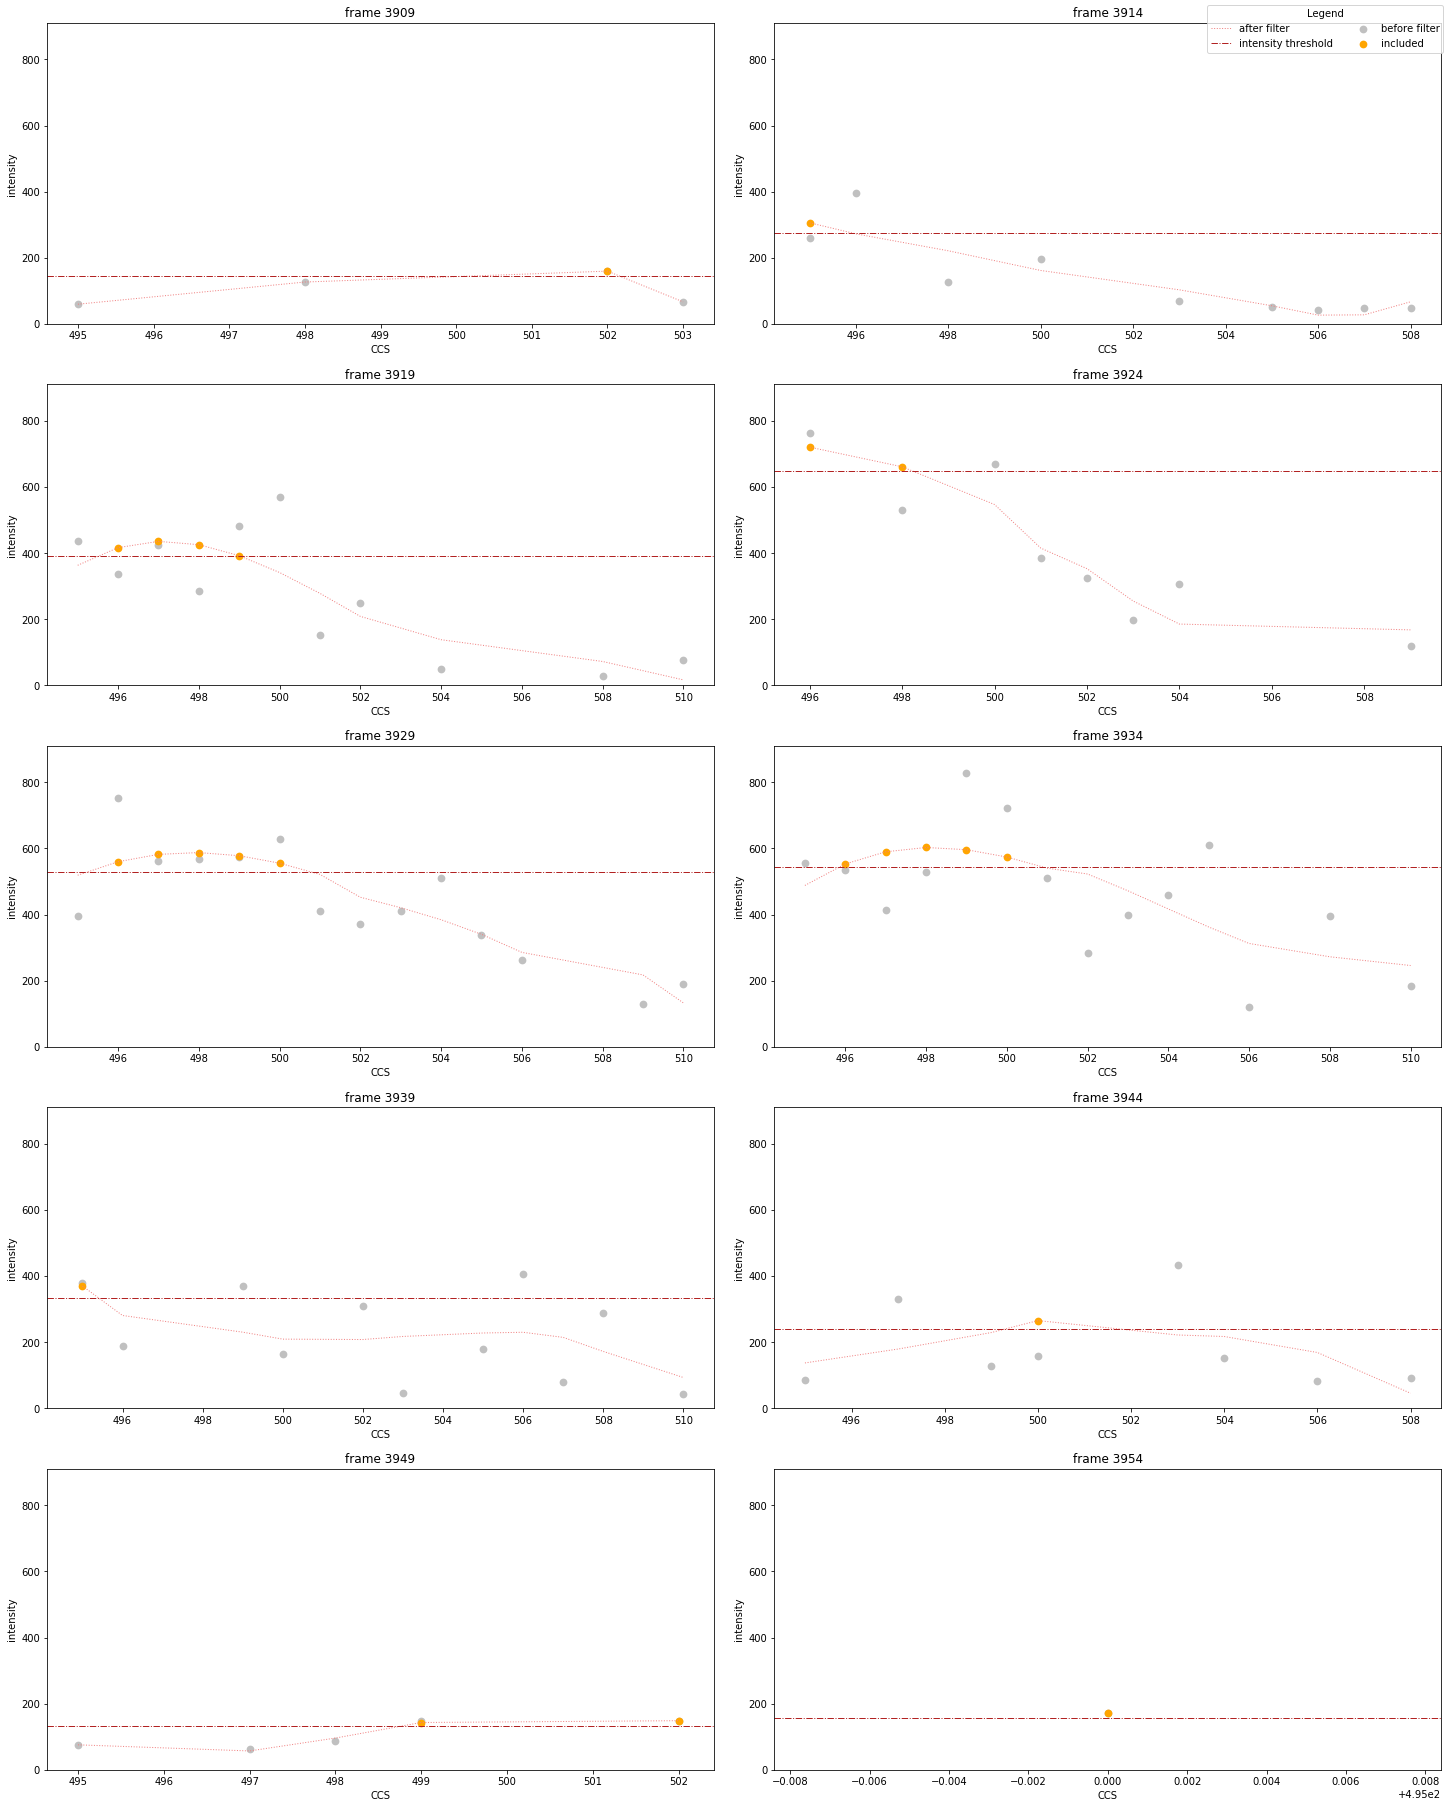

In [61]:
number_of_frames = len(monoisotope_df.frame_id.unique())
max_intensity = monoisotope_df.intensity.max()
number_of_rows = int(number_of_frames/2) + (number_of_frames % 2)

f, axarr = plt.subplots(nrows=number_of_rows, ncols=2, constrained_layout=True)
f.set_figheight(number_of_rows * 5)
f.set_figwidth(20)
# f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

max_labels = 0
for idx,ccs_cutoff in enumerate(frame_ccs_cutoffs):
    frame_df = monoisotope_df[(monoisotope_df.frame_id == ccs_cutoff[0])]  # the raw points for this frame
    frame_filtered_df = filtered_points_by_frame_l[idx]
    frame_includes_df = monoisotope_trimmed_by_ccs_cutoff_df[(monoisotope_trimmed_by_ccs_cutoff_df.frame_id == ccs_cutoff[0])]  # raw points above the cutoff and included in the intensity calc

    r = int(idx / 2)
    c = idx % 2

    ax = axarr[r,c]  # row, column
    ax.set_title('frame {}'.format(ccs_cutoff[0]))
    
    ax.scatter(frame_df.scan, frame_df.intensity, marker='o', color='silver', lw=0, s=60, alpha=1.0, label='before filter')
    ax.plot(frame_filtered_df.scan, frame_filtered_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='after filter')
    ax.scatter(frame_includes_df.scan, frame_includes_df.filtered_intensity, marker='o', color='orange', lw=0, s=60, alpha=1.0, label='included')
    
    ax.axhline(ccs_cutoff[1], color='firebrick', lw=1.0, ls='-.', label='intensity threshold')

    # set up axes
    ax.set_ylim((0,max_intensity*1.1))
    ax.set_xlabel('CCS')
    ax.set_ylabel('intensity')

    # make a legend from all possible labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > max_labels:
        max_labels = len(labels)
        superset_handles = handles
        superset_labels = labels

f.legend(superset_handles, superset_labels, loc='upper right', ncol=2, title="Legend", fancybox=True)

plt.show()    

In [62]:
monoisotope_trimmed_by_ccs_cutoff_df.columns

Index(['frame_id', 'intensity', 'mz', 'retention_time_secs', 'scan',
       'isotope_idx', 'filtered_intensity'],
      dtype='object')

In [63]:
# find the RT cutoff
filter_window_length = 9
rt_flattened_df = monoisotope_trimmed_by_ccs_cutoff_df.groupby(['frame_id','retention_time_secs'], as_index=False).filtered_intensity.sum()
rt_flattened_df.rename(columns={'filtered_intensity': 'intensity'}, inplace=True)  # because it's really just 'intensity'
rt_flattened_df['filtered_intensity'] = rt_flattened_df.intensity  # set up the default intensity
# order the points by frame
rt_flattened_df.sort_values(by=['frame_id'], ascending=[True], inplace=True)
# filter the points
number_of_points = len(rt_flattened_df)
if number_of_points >= polyorder+2:  # the next odd number above polyorder
    window_length = number_of_points if (number_of_points % 2 == 1) else number_of_points-1
    print("{} points, window length = {}".format(number_of_points, window_length))
    rt_flattened_df['filtered_intensity'] = signal.savgol_filter(rt_flattened_df.intensity, window_length=window_length, polyorder=polyorder)
else:
    print("not filtered")
max_rt_intensity = rt_flattened_df.filtered_intensity.max()
rt_intensity_cutoff = (1.0 - top_rt_proportion_to_include) * max_rt_intensity

# trim the RT-flattened monoisotope accordingly
rt_flattened_with_cutoff_df = rt_flattened_df[rt_flattened_df.filtered_intensity >= rt_intensity_cutoff]

# now sum the remaining points to calculate the intensity
intensity = rt_flattened_with_cutoff_df.filtered_intensity.sum()

10 points, window length = 9


#### visualise the RT cutoff

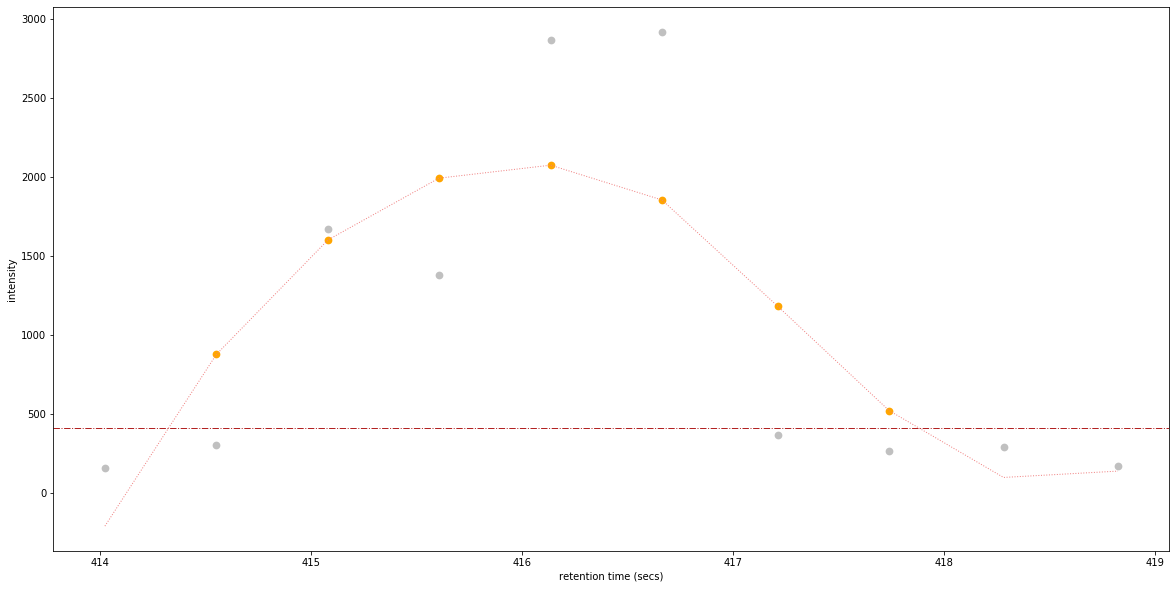

In [64]:
# visualise the RT cutoffs
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(20)
# f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

# ax.set_title('frame {}'.format(ccs_cutoff[0]))

ax.scatter(rt_flattened_df.retention_time_secs, rt_flattened_df.intensity, marker='o', color='silver', lw=0, s=60, alpha=1.0, label='before filter')
ax.plot(rt_flattened_df.retention_time_secs, rt_flattened_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='after filter')
ax.scatter(rt_flattened_with_cutoff_df.retention_time_secs, rt_flattened_with_cutoff_df.filtered_intensity, marker='o', color='orange', lw=0, s=60, alpha=1.0, label='included')

ax.axhline(rt_intensity_cutoff, color='firebrick', lw=1.0, ls='-.', label='intensity threshold')

# set up axes
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

plt.show()    